# Code Final Project Python Data Analysis

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn as sk
import seaborn as sns

### Dataset importation and first manipulations

In [2]:
name = ["SpMax_L","J_Dz","nHM","F01[N-N]","F04[C-N]","NssssC","nCb-","C%","nCp","nO","F03[C-N]","SdssC","HyWi_B(m)","LOC","SM6_L","F03[C-O]","Me","Mi","nN-N","nArNO2","nCRX3","SpPosA_B(p)","nCIR","B01[C-Br]","B03[C-Cl]","N-073","SpMax_A","Psi_i_1d","B04[C-Br]","SdO","TI2_L","nCrt","C-026","F02[C-N]","nHDon","SpMax_B(m)","Psi_i_A","nN","SM6_B(m)","nArCOOR","nX","experimental_class"]
data = pd.read_csv("biodeg.csv", sep=';',names=name)

In [3]:
data.head()

,SpMax_L,J_Dz,nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,...,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX,experimental_class
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,RB
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,RB
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,RB
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,RB
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,RB


In [4]:
#Conversion of experimental class into boolean (easier for next steps)
Biodegradability = []
for i in data.index:
    (Biodegradability.append(True if data.experimental_class[i] == 'RB' else False))
print(sum(Biodegradability))

data.experimental_class=Biodegradability

356


### Data Analysis

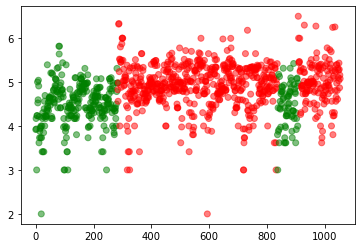

In [5]:
#I began with a scatter_plot of the first attribute colored in green if it represents a biodegradable element and in red if not
colors = np.where(data["experimental_class"]==1,'g','r')
plt.scatter(data.index,data.SpMax_L, c=colors, alpha=.5)

### Matrice de corrélation

In [6]:
data.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))

# Machine Learning

### Train/Test

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [8]:
X, y = data.drop('experimental_class', axis=1),data['experimental_class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

### Logistic Regression

In [9]:
model1 = LogisticRegression(solver='lbfgs',max_iter=1000) #I increased max_iter because of an error (TOTAL NO. of ITERATIONS REACHED LIMIT)
model1.fit(X_train,y_train)
y_pred = model1.predict(X_test)
LGaccuracy = metrics.accuracy_score(y_test, y_pred)
LGaccuracy

0.8530805687203792

### k-nearest Neighbors

In [10]:
model2 = KNeighborsClassifier()
model2.fit(X_train,y_train)
y_pred = model2.predict(X_test)
kNNaccuracy = metrics.accuracy_score(y_test, y_pred)
kNNaccuracy

0.8483412322274881

In [11]:
k_range = range(1,26)
scores = []
for k in k_range:
    model2 = KNeighborsClassifier(n_neighbors=k)
    model2.fit(X_train,y_train)
    y_pred = model2.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Accuracy')

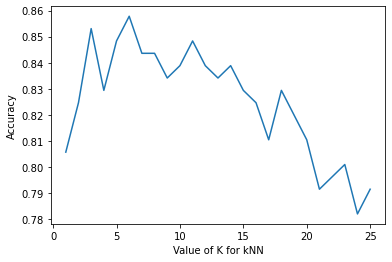

In [12]:
plt.plot(k_range, scores)
plt.xlabel('Value of K for kNN')
plt.ylabel('Accuracy')

In [13]:
maxAccKNN = max(scores)
bestValueOfK = np.argmax(scores)
print(maxAccKNN, '  avec un k =',bestValueOfK)

0.8578199052132701   avec un k = 5


### Partial Least Squares Discriminant Analysis

In [14]:
model3 = PLSRegression(n_components=2)
model3.fit(X_train, y_train)
y_pred = (model3.predict(X_test)[:,0] > 0.5).astype('uint8') 
#Because results of prediction are included between 0.0 and 1.0, and 0 or 1
PLSRegAccuracy = metrics.accuracy_score(y_test, y_pred)
PLSRegAccuracy

0.8483412322274881

In [15]:
parameters = {'n_components':[1,3], 'max_iter':[200,100,1000]}
model3 = PLSRegression()
clf=GridSearchCV(model3, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=PLSRegression(),
             param_grid={'max_iter': [200, 100, 1000], 'n_components': [1, 3]})

In [16]:
maxAccPLSReg = clf.score(X_test, y_test)
bestParamPLSReg = clf.best_params_
#bestPLSReg = clf.best_estimator_
print("Meilleure précision :", maxAccPLSReg)
print("Meilleurs parametres :", bestParamPLSReg)

Meilleure précision : 0.42128536956743845
Meilleurs parametres : {'max_iter': 200, 'n_components': 3}


### Support Vector Machines

In [17]:
model4 = svm.SVC()
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)
SVMAccuracy = metrics.accuracy_score(y_test, y_pred)
SVMAccuracy

0.8151658767772512

In [18]:
parameters = {'kernel':('linear','rbf'),'C':[1,10]}
model4 = svm.SVC()
clf = GridSearchCV(model4, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [19]:
maxAccSVM = clf.score(X_test, y_test)
bestParamSVM = clf.best_params_
#bestEstimSVM = clf.best_estimator_
print("Meilleure précision :", maxAccSVM)
print("Meilleurs parametres :", bestParamSVM)

Meilleure précision : 0.8625592417061612
Meilleurs parametres : {'C': 1, 'kernel': 'linear'}


### Confusion Matrix

In [20]:
print("Best Accuracy for each model :")
print("  Logistic regression :", LGaccuracy)
print("  kNN :", maxAccKNN)
print("  Partial Least Squares Regression :", maxAccPLSReg)
print("  Support Vector Machines :", maxAccSVM)

Best Accuracy for each model :
  Logistic regression : 0.8530805687203792
  kNN : 0.8578199052132701
  Partial Least Squares Regression : 0.42128536956743845
  Support Vector Machines : 0.8625592417061612


In [21]:
from sklearn.metrics import confusion_matrix
y_pred = pd.Series(model1.predict(X_test), name='Predicted')
df_confusion = confusion_matrix(y_test, y_pred) #as dataFrame

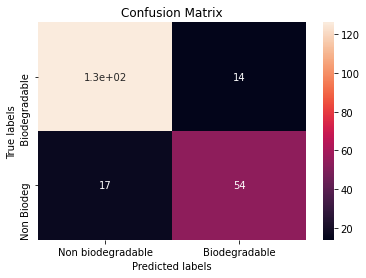

In [22]:
ax = plt.subplot()
sns.heatmap(df_confusion, annot=True, ax=ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Non biodegradable', 'Biodegradable']);
ax.yaxis.set_ticklabels(['  Biodegradable','Non Biodeg']);

### Exportation for the API

In [23]:
import pickle 
pickle.dump(model1, open('transfertModel.pkl','wb'))
defaultValues = np.array(X_train.loc[1])
pickle.dump(defaultValues, open('transertDefaultValues.pkl','wb'))